In [1]:
import sys
sys.path.append('/home/gleech/.cache/pypoetry/virtualenvs/insurance-4BC0dsBn-py3.8/lib/python3.8/site-packages')

In [2]:
import xgboost as xgb
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

%matplotlib inline

In [3]:
df = pd.read_csv("new_train/new_train.csv")

# Can't use these for prediction
posthoc_cols = ["Claim Reason", "Customer"]
df = df.drop(posthoc_cols, axis=1)

# Wait, is "Monthly Premium Auto" not the output of our process, rather than a feature?
# Run without it later.

# Check legality

In [4]:
gender_bans = ["California", "Hawaii", "Massachusetts", "Montana", "North Carolina", "Pennsylvania"]
#gender_bans_codes = ["CO", "HI", "MA", "MT", "NC", "PA"]
assert(df[df.State.isin(gender_bans)].empty)

# Onehot

In [5]:
categorical_features = ['Country', 'State Code', 'State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Location Code', \
                        'Marital Status', 'Policy Type', 'Policy', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']
cat_onehots = pd.get_dummies(df[categorical_features])

df = df.join(cat_onehots) \
        .drop(categorical_features, axis=1)


# Drop bullshit columns


In [6]:
def get_constant_cols(df) :
    bs = []
    for col in df.columns :
        if len(df[col].unique()) == 1:
            bs.append(col)
    return bs


df = df.drop(get_constant_cols(df), axis=1)


print("Any low-variance cols?", any(df.std() < 0.05) )

Any low-variance cols? False


## Any time trend?

[2011]


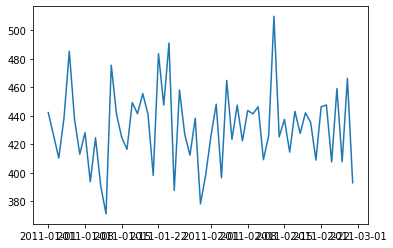

In [7]:
print(pd.to_datetime(df["Effective To Date"]).dt.year.unique())
# No annual trend then

time_trend = df[["Effective To Date","Total Claim Amount"]] \
                .groupby(pd.to_datetime(df["Effective To Date"])).mean()
plt.plot(time_trend.index, time_trend["Total Claim Amount"])
# Nothing

df = df.drop("Effective To Date", axis=1) 

# Consider fairness

In [8]:
# EmploymentStatus_Disabled!!! EmploymentStatus_Medical Leave!!!
unfair_cols = ["EmploymentStatus_Disabled", "EmploymentStatus_Medical Leave"]
# "Income" and "Education" arguably

df = df.drop(unfair_cols, axis=1)

In [9]:
y = df["Total Claim Amount"]
X = df.drop("Total Claim Amount", axis=1)


SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=SEED)
X_train.columns

Index(['Income', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'State Code_IA', 'State Code_KS', 'State Code_MO',
       'State Code_NE', 'State Code_OK', 'State_Iowa', 'State_Kansas',
       'State_Missouri', 'State_Nebraska', 'State_Oklahoma', 'Response_No',
       'Response_Yes', 'Coverage_Basic', 'Coverage_Extended',
       'Coverage_Premium', 'Education_Bachelor', 'Education_College',
       'Education_Doctor', 'Education_High School or Below',
       'Education_Master', 'EmploymentStatus_Employed',
       'EmploymentStatus_Retired', 'EmploymentStatus_Unemployed', 'Gender_F',
       'Gender_M', 'Location Code_Rural', 'Location Code_Suburban',
       'Location Code_Urban', 'Marital Status_Divorced',
       'Marital Status_Married', 'Marital Status_Single',
       'Policy Type_Corporate Auto', 'Policy Type_Personal Auto',
       'Policy Type_Special Auto', 'Policy_Corporate L1',
  

# Training a GBM

In [10]:
# Random grid

grid = {
        'learning_rate' : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
        'min_child_weight': [2, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'lambda': [0.0001, 0.001, 0.01, 0.1, 1]
        }

folds = 5
param_comb = 50

bst = xgb.XGBRegressor(n_estimators=250, \
                       objective='reg:gamma', \
                       base_score=y_train.median(),
                       eval_metric='mae',
                       booster='gbtree',
                       tree_method='exact')

skf = KFold(n_splits=folds, shuffle = True, random_state = SEED)

random_search = RandomizedSearchCV(bst, \
                                   param_distributions=grid, \
                                   n_iter=param_comb, \
                                   #n_jobs=-1, \
                                   cv=skf.split(X_train,y_train), \
                                   verbose=0, \
                                   random_state=SEED )
bst = random_search.fit(X_train, y_train)
print(bst.best_estimator_.get_params())

preds = bst.predict(X_val)
gridmae = mean_absolute_error(preds, y_val)
print(gridmae)

# {'objective': 'reg:gamma', 'base_score': 384.0, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 16, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'mae', 'lambda': 1}

{'objective': 'reg:gamma', 'base_score': 384.0, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 250, 'n_jobs': 16, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None, 'eval_metric': 'mae', 'lambda': 1}
73.31775900450292


In [11]:
BASELINE_MAE = 75   #1206

# Enforce monotonicity on numerics

In [12]:
def get_monotone_cols(df) :
    return [(c,i) for i,c in enumerate(df.columns) \
            if "_" not in c]

get_monotone_cols(X_train)

[('Income', 0),
 ('Monthly Premium Auto', 1),
 ('Months Since Last Claim', 2),
 ('Months Since Policy Inception', 3),
 ('Number of Open Complaints', 4),
 ('Number of Policies', 5)]

In [13]:
# Eyeballed directions for monotone
CONSTRAINTS = (-1,1,-1,-1,1,1)

In [15]:
params = bst.best_estimator_.get_params()
params['monotone_constraints'] = CONSTRAINTS
num_round = 250

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

mono = xgb.train(params, dtrain, num_round)
preds = mono.predict(dval)
monomae = mean_absolute_error(preds, y_val)

print("monotonic MAE, ", monomae)
print("How much does monotonicity cost us per customer?: $", round(monomae - gridmae, 2))

[12:57:43] WARNING: ../src/learner.cc:541: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


monotonic MAE,  75.67241252665274
How much does monotonicity cost us per customer?: $ 2.35


# Take out possibly invalid feature

In [17]:
X_train_noprem = X_train.drop("Monthly Premium Auto", axis=1)
X_val_noprem = X_val.drop("Monthly Premium Auto", axis=1)
X_test_noprem = X_test.drop("Monthly Premium Auto", axis=1)

best_params = bst.best_estimator_.get_params()
no_prem = xgb.XGBRegressor(**best_params)
no_prem.fit(X_train_noprem, y_train)
preds = no_prem.predict(X_val_noprem)
mean_absolute_error(preds, y_val)


78.2513181831189

# Feature importances

<AxesSubplot:>

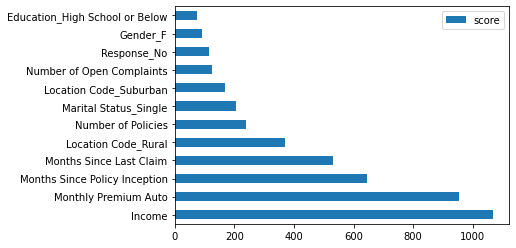

In [18]:
feature_important = bst.best_estimator_.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data.head(12).plot(kind='barh')

# Shapley values

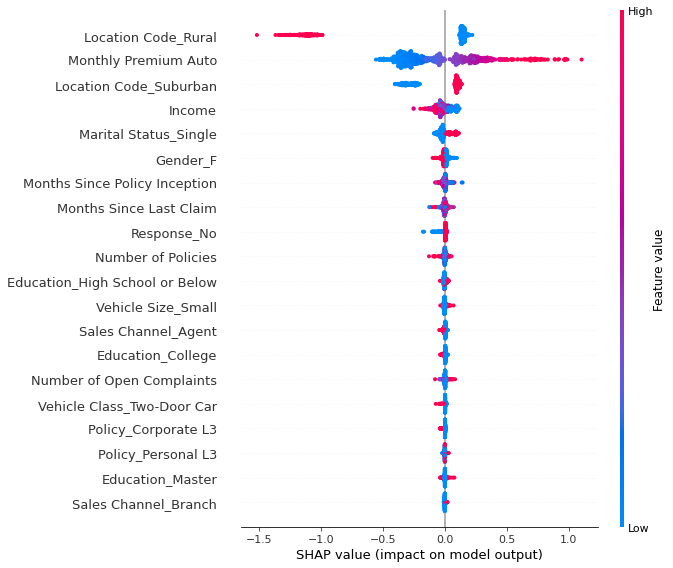

In [21]:
shap.initjs()

preds = bst.predict(X_val)
explainer = shap.TreeExplainer(bst.best_estimator_.get_booster())
shap_values = explainer.shap_values(dval)
shap.summary_plot(shap_values, X_val)

In [22]:
# "explain" one point
shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])

# Compare dumb linreg

In [24]:
# specify parameters via map
param = { 'eta':0.01, \
         'objective':'reg:gamma', \
         'eval_metric': 'mae',
         'base_score' : df["Total Claim Amount"].median(),
         'booster': 'gblinear', \
         # Enforce increasing/decreasing
         #'monotone_constraints': (-1,1,1),#tuple([1 for c in X_train.columns])
         'lambda': 0.1
        }
num_round = 1000
lin = xgb.train(param, dtrain, num_round)
preds = lin.predict(dval)
mean_absolute_error(preds, y_val)

85.07932602563051

# Final perf

In [25]:
dtest = xgb.DMatrix(X_test, label=y_test)
preds = bst.predict(X_test)
mono_preds = mono.predict(dtest)
no_prem_preds = no_prem.predict(X_test_noprem)

print("Grid model test MAE:", mean_absolute_error(preds, y_test))
print("With monotonicity, test MAE:", mean_absolute_error(mono_preds, y_test))
print("Without monthly premium feature, test MAE:", mean_absolute_error(no_prem_preds, y_test))


Grid model test MAE: 71.99056050488709
With monotonicity, test MAE: 72.6401939479017
Without monthly premium feature, test MAE: 74.64407243779213
